## Setup and Imports

In [3]:
import pandas as pd
from utilities import read_companys_dataset2018, read_base_dataset

In [2]:
# Read the dataset
pd.set_option('mode.use_inf_as_na', True) # convert inf to nan
base_df = read_base_dataset("2018")
company_df = read_companys_dataset2018()

Number of Base Dataset Columns: 80
Number of Own Dataset Columns: 84

Number of Columns to correct : 52
Number of corrected labels from `token_sort_ratio` : 48


In [4]:
# Convert Labels to Binary Class
base_df['Label'] = base_df['Label'].apply(lambda x: 0 if 'BENIGN' in x else 1)
company_df.drop('Label', axis=1, inplace=True)

In [5]:
print("<< Base Dataset >>")
print("Original Size:", base_df.shape[0])
base_df.dropna(axis=0, inplace=True)
print("Reduced Size:", base_df.shape[0])


<< Base Dataset >>
Original Size: 1048575
Reduced Size: 1048575


## EDA

In [7]:
base_df.columns == company_df.columns

ValueError: Lengths must match to compare

We need to extract only a portion of the dataset so we don't spend too much time training

## Training
Split the dataset into training and validation

In [11]:
# Random choice to reduce the size of the dataset
base_df = base_df.sample(frac=0.1, random_state=42)
print("Number of Records in Smaller Dataset:", base_df.shape[0])

Number of Records in Smaller Dataset: 104858


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(base_df.iloc[:,0:-1],base_df['Label'], test_size=0.3, random_state=42)

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel


pipe = Pipeline([('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier(n_neighbors =5, algorithm = 'ball_tree', leaf_size=500))])

In [9]:
pipe_f = pipe.fit(X_train, y_train)

ValueError: could not convert string to float: '21/02/2018 02:25:49'

In [13]:
SelectFromModel(pipe, prefit=True)

SelectFromModel(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                          ('knn',
                                           KNeighborsClassifier(algorithm='ball_tree',
                                                                leaf_size=500))]),
                prefit=True)

In [9]:
# Test on VALIDATION set
print("<< Validation Score >>", pipe.score(X_val, y_val))

<< Validation Score >> 0.9988186650915535


Predict on Validation set & Score it

In [10]:
y_predict = pipe.predict(X_val)

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_val, y_predict)
precision = precision_score(y_val, y_predict)
recall = recall_score(y_val, y_predict)
print("<< Validation Set Results >>")
print("Recall is {}." .format(round(recall,4)))
print("F is {}.".format(round(f1_score(y_val,y_predict),4)))

<< Validation Set Results >>
Recall is 0.999.
F is 0.999.


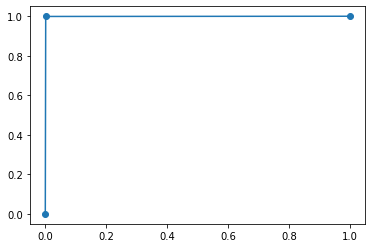

AUC is 0.999.


In [12]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_predict, pos_label=1)
plt.plot(fpr,tpr,marker = 'o')
plt.show()
from sklearn.metrics import auc
AUC = auc(fpr, tpr)
print ("AUC is {}.".format(round(recall,4)))

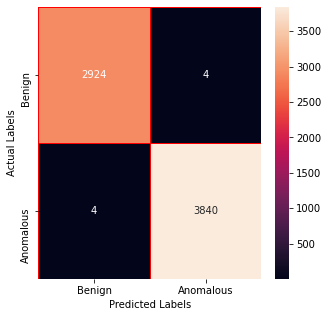

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
cm = confusion_matrix(y_val, y_predict)

class_labels = ['Benign', 'Anomalous']
plot_labels = {"xticklabels": class_labels, 
               "yticklabels": class_labels}

f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True, linewidth =0.5, linecolor ="red", fmt =".0f", ax=ax, **plot_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()


## Feature Importante Post-training

In [18]:
from sklearn.feature_selection import RFE
pipe['knn'].features_importances_
# features_ranking = RFE(pipe)

AttributeError: 'KNeighborsClassifier' object has no attribute 'features_importances_'

## Test Data A.K.A. Company's Data

In [ ]:
predictions_test = pipe.predict(company_df)
predictions_test

In [ ]:
# Create a new label column based off the predictions
convert_to_classlabels = lambda value : 'BENIGN' if value == 0 else 'ANOMALOUS'
company_df['Label'] = list(map(convert_to_classlabels, predictions_test))
company_df.head()

## Final Result

In [ ]:
# Count
company_df.Label.value_counts()